# Flesch-Kincaid Readability Analysis of Trump's Speeches

This notebook performs a readability analysis on Donald Trump's speeches. We use the **Flesch-Kincaid Grade Level**, **Gunning Fog Index**, and **Flesch Reading Ease** to evaluate the complexity of his language.

## Objectives
1.  **Aggregate Transcriptions**: Combine individual transcription segments into full speeches.
2.  **Filter Data**: Remove speeches before 2010 to focus on his political era.
3.  **Calculate Metrics**: Compute readability scores for each speech.
4.  **Analyze Trends**: Visualize how readability has changed over time and across campaigns.

## Metrics Explained
-   **Flesch-Kincaid Grade Level**: Corresponds to a U.S. school grade level. For example, a score of 8.0 means an 8th grader can understand the text.
-   **Gunning Fog Index**: Estimates the years of formal education a person needs to understand the text on the first reading.
-   **Flesch Reading Ease**: Scores text on a scale of 0-100. Higher scores indicate easier reading (e.g., 90-100 is very easy, 0-30 is very confusing).

In [12]:
import sys
import os
from pathlib import Path

# Add src to path
project_root = Path("..").resolve()
sys.path.append(str(project_root / "src"))


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textstat
import nltk
import ssl
import numpy as np
from filtering_corpus.speech_corpus import SpeechCorpus
from filtering_corpus.other_candidates import OtherCandidatesCorpus

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 7)

# Fix for NLTK download SSL error
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download necessary NLTK data
nltk.download('cmudict', quiet=True)
nltk.download('punkt', quiet=True)

True

## 1. Load and Preprocess Data

We load the corpus and filter out speeches before 2010 to focus on relevant political speeches. We then aggregate the transcriptions to get the full text for each speech.


We also verify the presence of the `cleaned_transcription` column, which contains lemmatized text essential for accurate lexical diversity analysis.

In [13]:
print("Loading corpus...")
# 1. Load Trump Speeches
corpus = SpeechCorpus(data_dir="../data", transcription_file="transcriptions.parquet")
print(f"Initial Trump Corpus: {corpus}")
# Filter speeches before 2010
corpus = corpus.remove_speeches_before(2010)
print(f"Filtered Trump Corpus: {corpus}")
df_trump = corpus.get_full_speeches()
df_trump['candidate'] = 'Trump'

# 2. Load Other Candidates
print("Loading other candidates...")
other_corpus = OtherCandidatesCorpus(data_dir="../data")

# Kamala Harris
kamala_corpus = other_corpus.get_kamala()
df_kamala = kamala_corpus.get_full_speeches()
df_kamala['candidate'] = 'Harris'
# Add missing columns for compatibility
df_kamala['date'] = None # We don't have dates yet
df_kamala['title'] = 'Speech: Kamala Harris'
df_kamala['is_rally'] = False
print(f"Kamala Harris Speeches: {len(df_kamala)}")

# Joe Biden
biden_corpus = other_corpus.get_biden()
df_biden = biden_corpus.get_full_speeches()
df_biden['candidate'] = 'Biden'
# Add missing columns for compatibility
df_biden['date'] = None
df_biden['title'] = 'Speech: Joe Biden'
df_biden['is_rally'] = False
print(f"Joe Biden Speeches: {len(df_biden)}")

# 3. Combine All
df = pd.concat([df_trump, df_kamala, df_biden], ignore_index=True)

# We verify that the cleaned transcription is available for lexical diversity analysis
if 'cleaned_transcription' not in df.columns:
    print("Warning: 'cleaned_transcription' column not found. Lexical diversity analysis will be limited.")

print(f"Total full speeches for analysis: {len(df)}")
print(df['candidate'].value_counts())


Loading corpus...
Initial Trump Corpus: <SpeechCorpus: 894 speeches, 121034 transcriptions>
Filtered Trump Corpus: <SpeechCorpus: 872 speeches, 118568 transcriptions>
Loading other candidates...
Kamala Harris Speeches: 18
Joe Biden Speeches: 40
Total full speeches for analysis: 924
candidate
Trump     866
Biden      40
Harris     18
Name: count, dtype: int64


/var/folders/c1/0gryp8dd5fg4sff058v3gb4m0000gn/T/ipykernel_58259/341992581.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df_trump, df_kamala, df_biden], ignore_index=True)


## 2. Calculate Readability Metrics

We define a function to calculate the metrics and apply it to the full text of each speech.

In [14]:
def calculate_readability_metrics(text):
    """
    Calculate readability metrics for a given text using textstat.
    Returns a dictionary with the scores.
    """
    if not isinstance(text, str) or not text.strip():
        return {
            "flesch_kincaid_grade": None,
            "gunning_fog": None,
            "flesch_reading_ease": None
        }
        
    try:
        return {
            "flesch_kincaid_grade": textstat.flesch_kincaid_grade(text),
            "gunning_fog": textstat.gunning_fog(text),
            "flesch_reading_ease": textstat.flesch_reading_ease(text)
        }
    except Exception as e:
        return {
            "flesch_kincaid_grade": None,
            "gunning_fog": None,
            "flesch_reading_ease": None
        }

print("Calculating Flesch-Kincaid and other readability metrics...")
# Calculate standard readability on original text (as it relies on sentence structure)
results_readability = df['text'].apply(calculate_readability_metrics)
df_readability = pd.json_normalize(results_readability)

# Concatenate readability results
df = pd.concat([df, df_readability], axis=1)

# Drop rows where calculation failed
df = df.dropna(subset=['flesch_kincaid_grade'])

# Remove outliers (e.g. grade level > 100)
df = df[df['flesch_kincaid_grade'] < 100]

print(f"Successfully processed readability for {len(df)} speeches.")
df[['title', 'date', 'flesch_kincaid_grade', 'gunning_fog', 'flesch_reading_ease']].head()

Calculating Flesch-Kincaid and other readability metrics...
Successfully processed readability for 923 speeches.


,title,date,flesch_kincaid_grade,gunning_fog,flesch_reading_ease
0,Speech: Donald Trump Addresses Service Members...,2025-10-05,4.996115,6.733310,78.578304
1,Speech: Donald Trump Addresses Military Leader...,2025-09-30,5.089434,7.069591,80.756945
2,Speech: Donald Trump Addresses the 80th Sessio...,2025-09-23,7.454008,9.281570,68.044575
3,Speech: Donald Trump Addresses a Memorial for ...,2025-09-21,6.050480,7.841183,74.432363
4,Speech: Donald Trump Addresses the American Co...,2025-09-20,4.468635,6.543872,81.586867


## 3. Lexical Diversity Analysis (TTR & CTTR)

This section focuses on the diversity of vocabulary used in the speeches. We use **Corrected Type-Token Ratio (CTTR)**, which is defined as:

$$ CTTR = \frac{\text{Unique Words}}{\sqrt{2 \times \text{Total Words}}} $$

CTTR is preferred over simple TTR because it corrects for the varying lengths of speeches (longer speeches tend to have lower simple TTR).

**Data Source**: We use the **cleaned (lemmatized)** text for this analysis. This ensures that different forms of the same word (e.g., "run", "running", "ran") are counted as a single concept, providing a more accurate measure of *conceptual* diversity.

In [4]:
def calculate_lexical_diversity(text):
    """
    Calculate Simple TTR and CTTR.
    """
    if not isinstance(text, str) or not text.strip():
        return {"TTR": None, "CTTR": None}
    
    tokens = text.split()
    total_words = len(tokens)
    unique_words = len(set(tokens))
    
    if total_words == 0:
        return {"TTR": 0, "CTTR": 0}
        
    ttr = unique_words / total_words
    cttr = unique_words / np.sqrt(2 * total_words)
    
    return {"TTR": ttr, "CTTR": cttr}

print("Calculating lexical diversity...")

# 1. Calculate on CLEANED text (Primary Metric)
if 'cleaned_transcription' in df.columns:
    print("Processing cleaned text (lemmatized)...")
    # Calculate diversity on lemmatized text to capture conceptual diversity
    results_diversity_clean = df['cleaned_transcription'].apply(calculate_lexical_diversity)
    df_diversity_clean = pd.json_normalize(results_diversity_clean)
    df_diversity_clean.columns = [f"{col}_clean" for col in df_diversity_clean.columns]
    
    # Add to main dataframe
    df = pd.concat([df.reset_index(drop=True), df_diversity_clean.reset_index(drop=True)], axis=1)
    
    # Set main CTTR column
    df['CTTR'] = df['CTTR_clean']
else:
    print("ERROR: 'cleaned_transcription' column not found. Please check data loading.")
    df['CTTR'] = np.nan

# 2. Calculate on UNCLEANED text (For Comparison)
print("Processing uncleaned text (for comparison)...")
results_diversity_raw = df['text'].apply(calculate_lexical_diversity)
df_diversity_raw = pd.json_normalize(results_diversity_raw)
df_diversity_raw.columns = [f"{col}_raw" for col in df_diversity_raw.columns]

df = pd.concat([df, df_diversity_raw], axis=1)

print("Lexical diversity calculation complete.")
df[['title', 'date', 'CTTR']].head()

Calculating lexical diversity...
Processing cleaned text...
Processing uncleaned text (for comparison)...
Lexical diversity calculation complete.


,title,date,CTTR
0,Speech: Donald Trump Addresses Service Members...,2025-10-05,13.792021
1,Speech: Donald Trump Addresses Military Leader...,2025-09-30,12.762446
2,Speech: Donald Trump Addresses the 80th Sessio...,2025-09-23,15.019598
3,Speech: Donald Trump Addresses a Memorial for ...,2025-09-21,13.093900
4,Speech: Donald Trump Addresses the American Co...,2025-09-20,11.880447


### Analysis of CTTR

**Interpretation**:
The violin plot above illustrates the distribution of lexical diversity (CTTR) across different speech types. 
- **Rallies**: Typically show a specific distribution pattern. If the CTTR is lower, it suggests a more repetitive vocabulary, which is common in campaign rhetoric designed to reinforce specific slogans and messages.
- **Other Speeches**: May exhibit a wider range or higher average CTTR, indicating a more varied vocabulary used in official or non-campaign contexts.

The descriptive statistics below provide a quantitative breakdown.

## 3. Analysis and Visualization

### 3.1 Evolution Over Time

Let's see how the **Flesch-Kincaid Grade Level** has evolved over time. We'll use a scatter plot with a rolling average trendline.

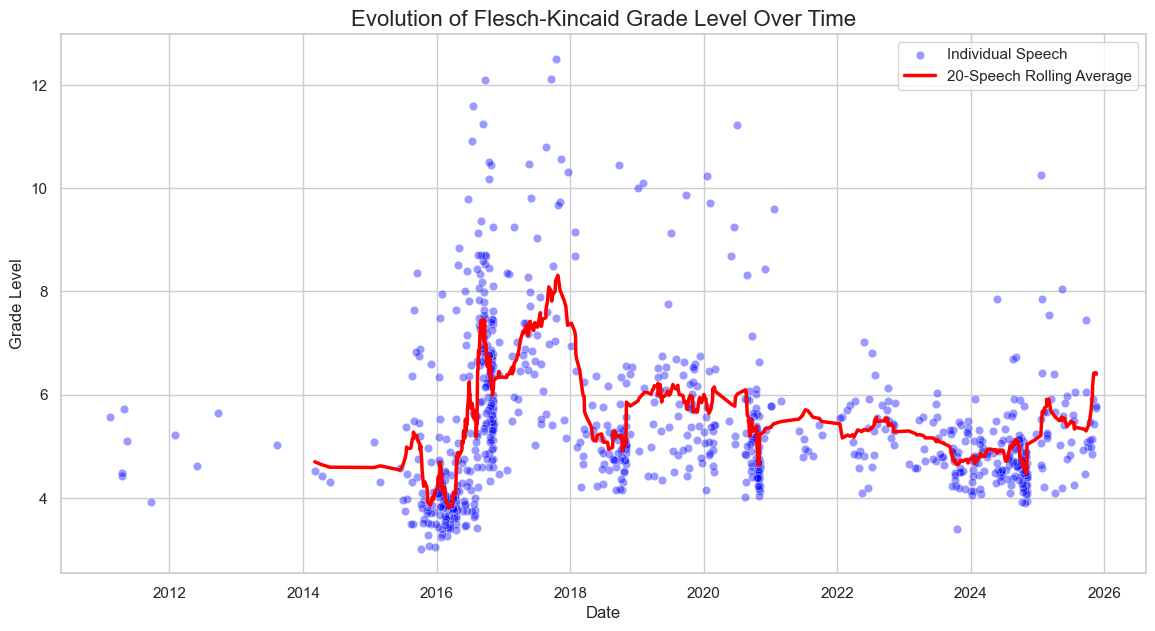

In [20]:
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df, x='date', y='flesch_kincaid_grade', alpha=0.4, color='blue', label='Individual Speech')

# Calculate rolling mean for trendline
df_sorted = df.sort_values('date')
df_sorted['rolling_grade'] = df_sorted['flesch_kincaid_grade'].rolling(window=20, center=True).mean()

sns.lineplot(data=df_sorted, x='date', y='rolling_grade', color='red', linewidth=2.5, label='20-Speech Rolling Average')

plt.title('Evolution of Flesch-Kincaid Grade Level Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Grade Level', fontsize=12)
plt.legend()
plt.show()

### 3.2 Comparison by Campaign Cycle

We compare the readability metrics across different campaign cycles (2016, 2020, 2024).

/var/folders/c1/0gryp8dd5fg4sff058v3gb4m0000gn/T/ipykernel_58259/2993986730.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=campaign_df, x='campaign', y='flesch_kincaid_grade', order=['2016', '2020', '2024'], palette='Set2')


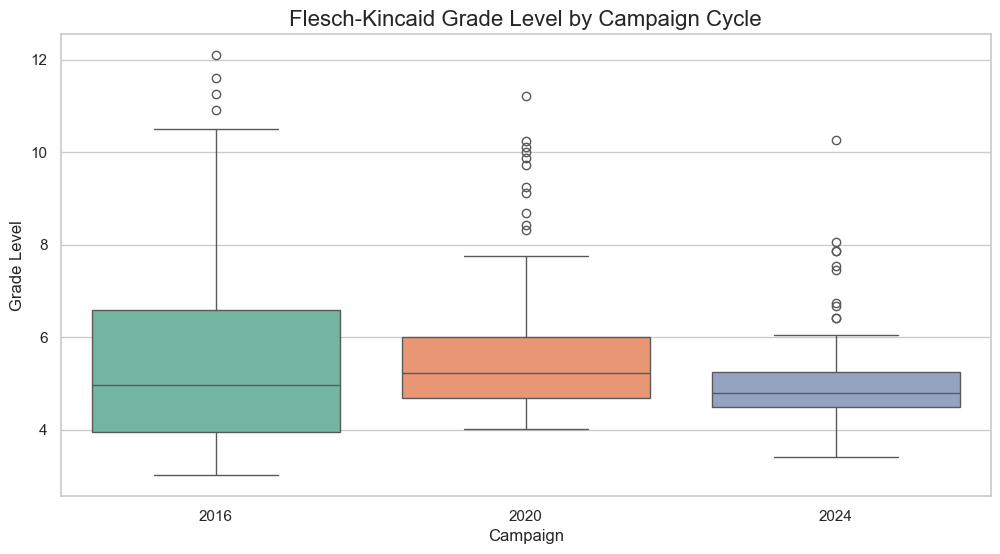

          count      mean       std       min       25%       50%       75%  \
campaign                                                                      
2016      305.0  5.415597  1.773895  3.015918  3.953273  4.963332  6.581924   
2020      153.0  5.562403  1.346336  4.020023  4.678782  5.225233  6.007714   
2024      221.0  4.969929  0.780682  3.402145  4.501057  4.800103  5.241922   

                max  
campaign             
2016      12.094732  
2020      11.219081  
2024      10.265530  


In [21]:
# Filter for main campaigns
campaign_df = df[df['campaign'].isin(['2016', '2020', '2024'])].copy()

plt.figure(figsize=(12, 6))
sns.boxplot(data=campaign_df, x='campaign', y='flesch_kincaid_grade', order=['2016', '2020', '2024'], palette='Set2')
plt.title('Flesch-Kincaid Grade Level by Campaign Cycle', fontsize=16)
plt.xlabel('Campaign', fontsize=12)
plt.ylabel('Grade Level', fontsize=12)
plt.show()

# Print summary statistics
print(campaign_df.groupby('campaign')['flesch_kincaid_grade'].describe())

### 3.3 Comparison by Speech Category

Does the complexity of speech vary by category (e.g., Rally vs. Official Speech)? Note: Categories might be sparse, so we'll check the most common ones.

/var/folders/c1/0gryp8dd5fg4sff058v3gb4m0000gn/T/ipykernel_58259/258788234.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Speech Type', y='flesch_kincaid_grade', palette='muted', split=True)


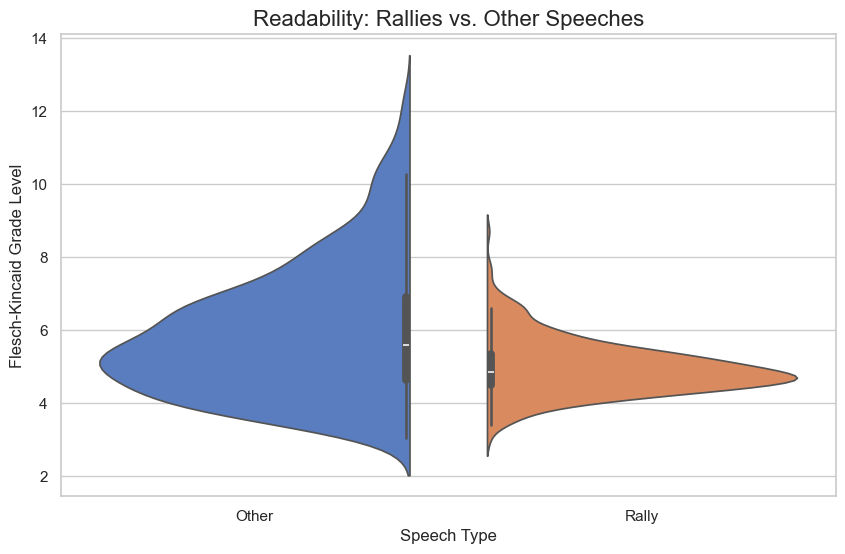

             count      mean       std       min       25%       50%  \
Speech Type                                                            
Other        545.0  5.959392  1.799712  3.042276  4.622211  5.595458   
Rally        378.0  4.965179  0.751413  3.015918  4.490509  4.846189   

                  75%        max  
Speech Type                       
Other        6.895469  12.508775  
Rally        5.334997   8.706052  


In [22]:
# Explode categories if they are lists, or just use them if strings
# Assuming 'categories' column exists and might need cleaning

# For this analysis, let's compare Rallies vs Non-Rallies
df['Speech Type'] = df['is_rally'].apply(lambda x: 'Rally' if x else 'Other')

plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='Speech Type', y='flesch_kincaid_grade', palette='muted', split=True)
plt.title('Readability: Rallies vs. Other Speeches', fontsize=16)
plt.xlabel('Speech Type', fontsize=12)
plt.ylabel('Flesch-Kincaid Grade Level', fontsize=12)
plt.show()

print(df.groupby('Speech Type')['flesch_kincaid_grade'].describe())

## 4. Conclusion

### Summary of Findings

The Flesch-Kincaid Grade Level corresponds directly to U.S. school grade levels.

Rallies (Mean: ~4.97): This indicates a 5th-grade reading level (roughly 10–11 years old). The language used is very simple, likely consisting of short sentences and common vocabulary.
Other Speeches (Mean: ~5.80): This indicates nearly a 6th-grade reading level (roughly 11–12 years old). These speeches are slightly more complex than rallies but still very accessible.

Compared to General English: A "standard" conversational or plain English level is often considered to be around 7th to 8th grade. Professional or academic documents are usually 10th grade and above.
Compared to Historical Presidents: Most modern U.S. presidents have spoken at an 8th to 10th-grade level in their speeches. Donald Trump is statistically known for using unique, simpler rhetoric compared to his predecessors, often falling in the 4th–6th grade range.
Rally vs. Non-Rally: It is "normal" for his Rallies to be lower (4.97) than Other speeches (5.80). Rallies rely on extemporaneous speaking, punchy slogans, and repetition, which naturally lowers the grade level score. "Other" speeches likely include prepared remarks or teleprompter events, which tend to have more structured sentences.